# Ladder Wise Pre-Training

## Theory

- Autoencoding one layer at a time

|<b> Ladder Wise PreTraining </b>| <b>End To End Training </b>|
|:--:|:--:|
|Lesser memory needed , since iterative steps, less weights|More Memory Needed|
|Fewer weights lost |More weights lost|

                

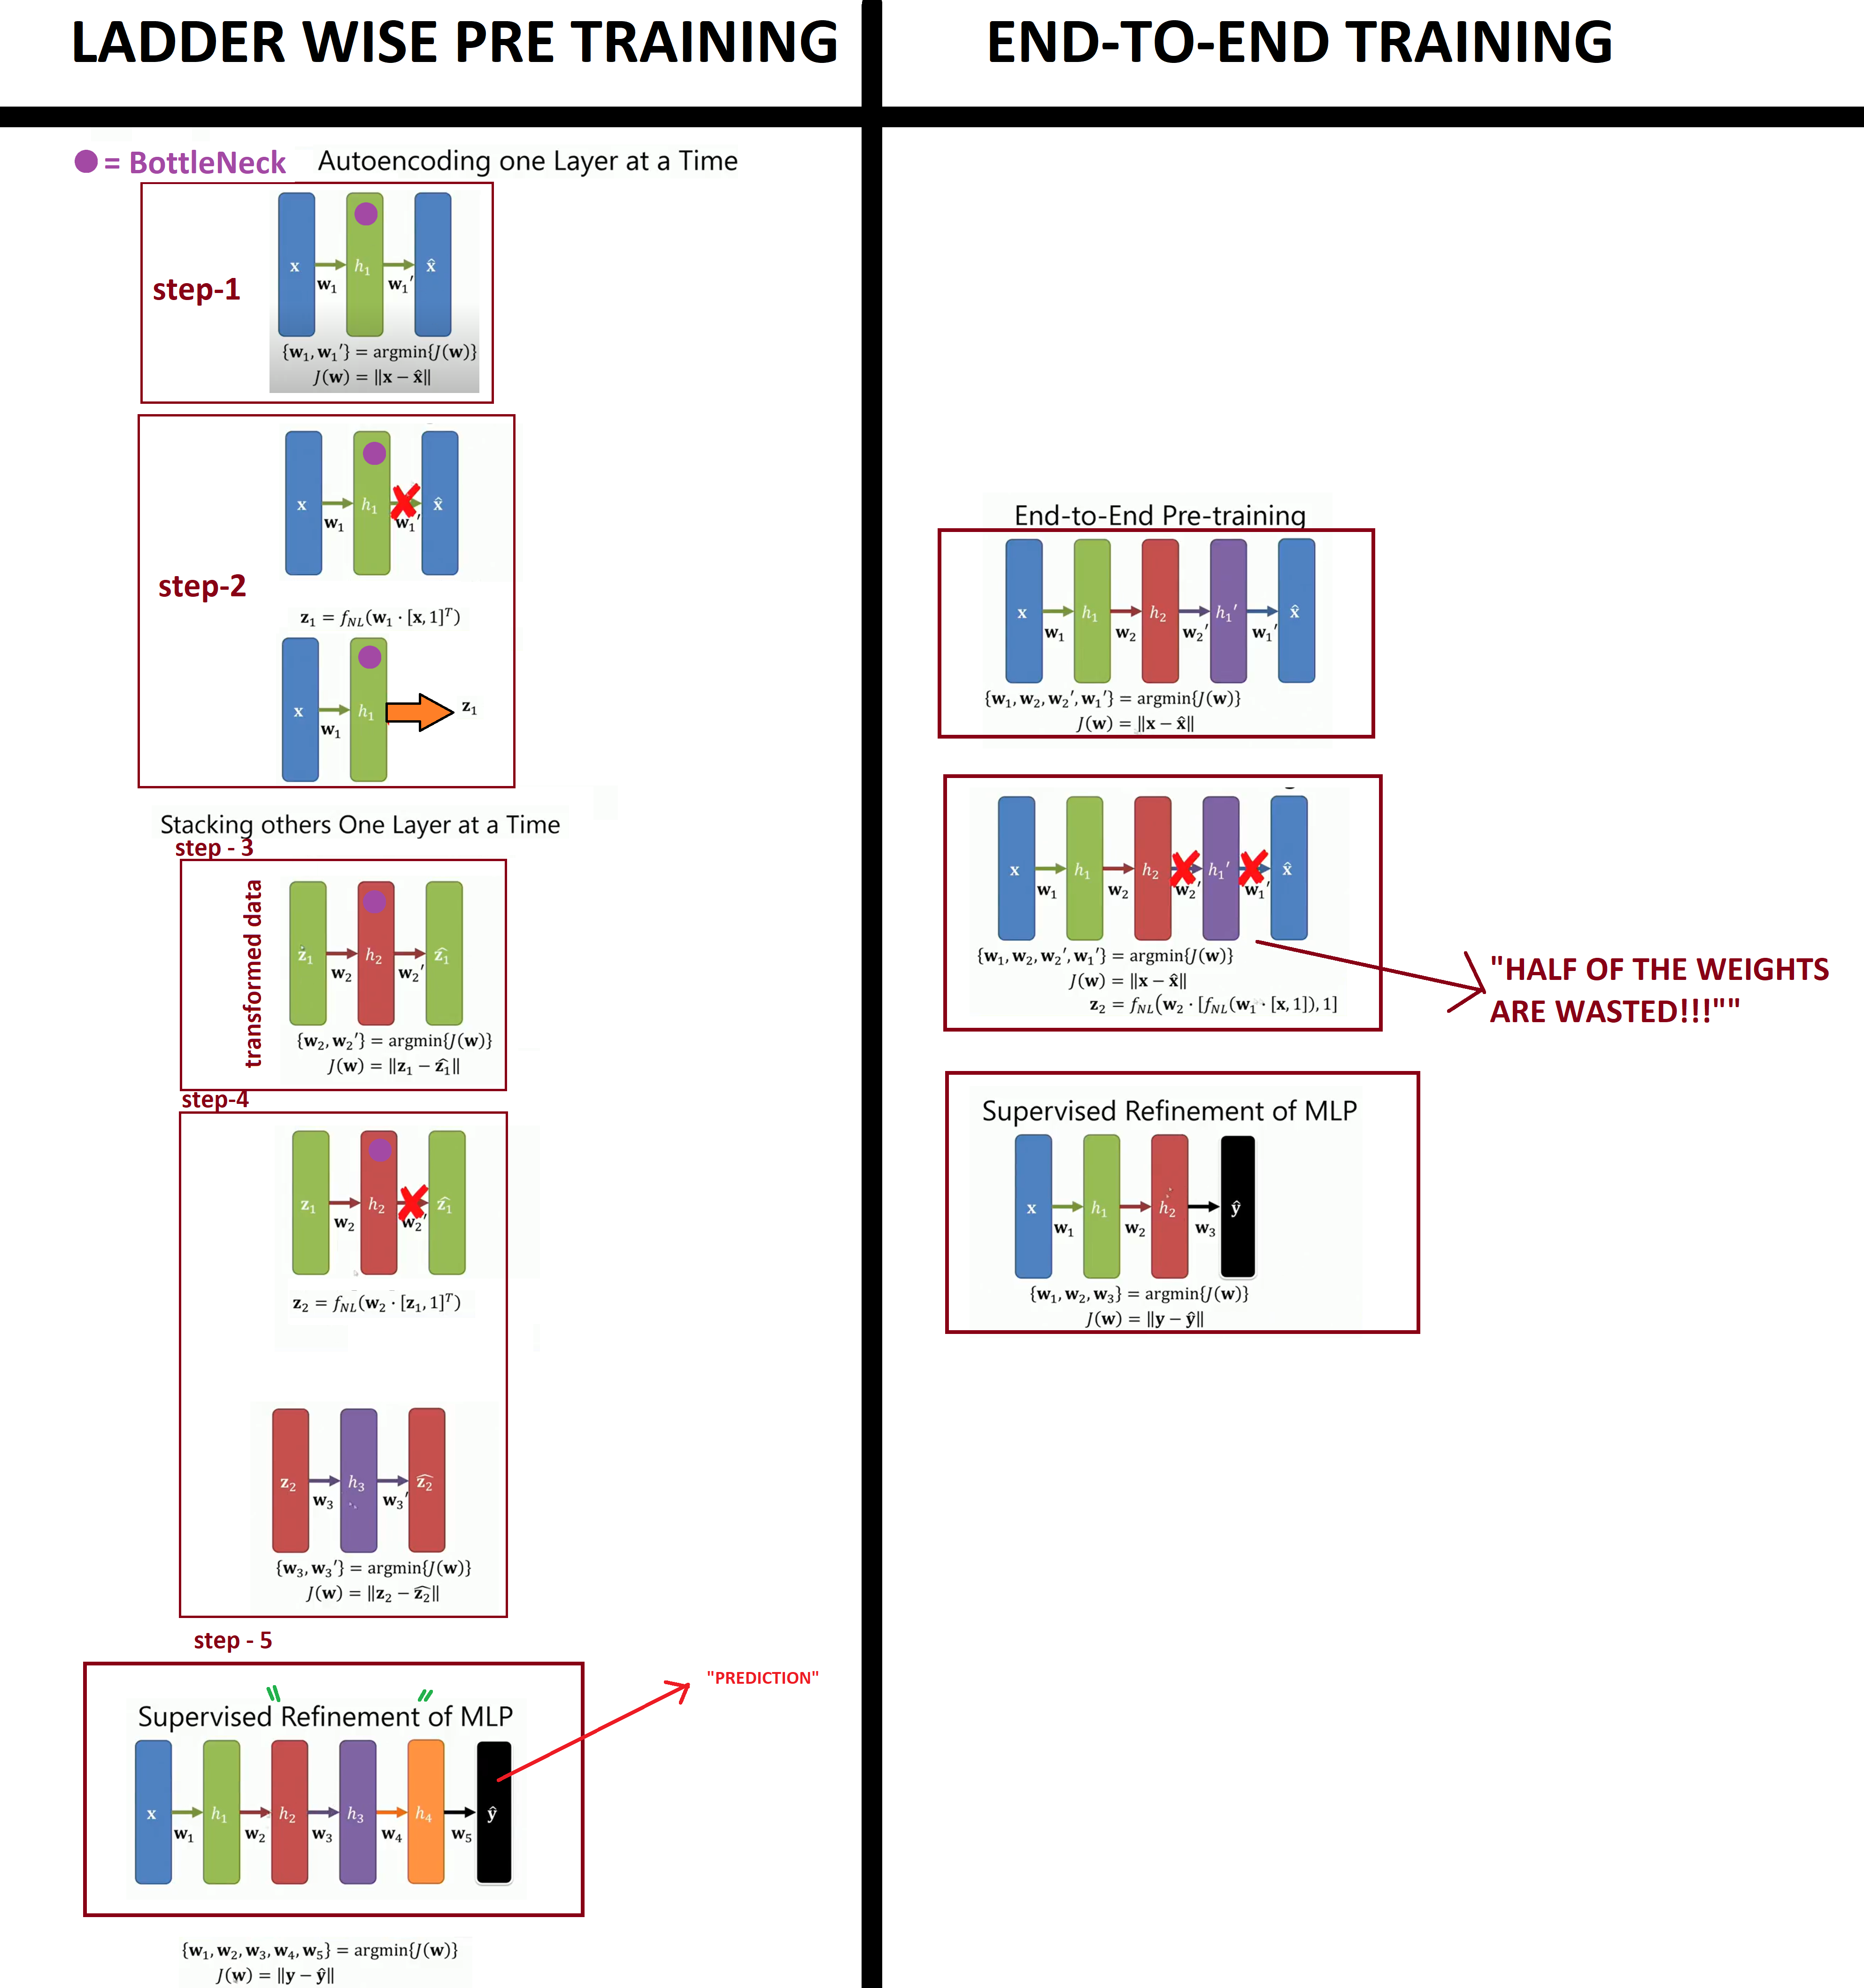

##  MNIST with Stacked Autoencoders


### Load Packages


In [1]:
%matplotlib inline
import torch
import numpy as np
import torchvision
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

1.5.0


### Load Data:


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 1000

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

0it [00:00, ?it/s]

9920512it [00:01, 6738873.02it/s]                             


Extracting ./MNIST\MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\MNIST\raw


0it [00:00, ?it/s]

32768it [00:00, 96154.06it/s]            
0it [00:00, ?it/s]

Extracting ./MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\MNIST\raw


1654784it [00:00, 2127933.91it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\MNIST\raw


8192it [00:00, 31701.91it/s]            
..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Extracting ./MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\MNIST\raw
Processing...
Done!


In [3]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is available!


### Define the Autoencoder:


<b> 784 -> 400 -> 784</b>

In [5]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(400, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
net = autoencoder()
print(net)

net = net.double().to(device)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


### Train Autoencoder:


In [8]:
iterations = 10
learning_rate = 0.98
criterion = nn.MSELoss()  #since, replicate the same input (L-2 Norm)

In [9]:
for epoch in range(iterations):  # loop over the dataset multiple times
    runningLoss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28*28).double().to(device)
        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) 
            # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.item()
        
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
print('Finished Training')

At Iteration : 1 / 10  ;  Mean-Squared Error : 0.191042
At Iteration : 2 / 10  ;  Mean-Squared Error : 0.099815
At Iteration : 3 / 10  ;  Mean-Squared Error : 0.077365
At Iteration : 4 / 10  ;  Mean-Squared Error : 0.072395
At Iteration : 5 / 10  ;  Mean-Squared Error : 0.070347
At Iteration : 6 / 10  ;  Mean-Squared Error : 0.069157
At Iteration : 7 / 10  ;  Mean-Squared Error : 0.068306
At Iteration : 8 / 10  ;  Mean-Squared Error : 0.067606
At Iteration : 9 / 10  ;  Mean-Squared Error : 0.066970
At Iteration : 10 / 10  ;  Mean-Squared Error : 0.066351
Finished Training


### Stacking Layers:


<b> 784 -> 400 -> 784</b>

In [10]:
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


<b> (784 -> 400) -> 256 -> (400-> 784)</b> <br>
() - > Prevous Trained Weights

In [11]:
# Adding New Layer (Stacking)
net.encoder.add_module('New_Encoder_Layer', nn.Sequential(nn.Linear(400, 256),nn.Tanh()))
net.encoder.add_module('New_Decoder_Layer', nn.Sequential(nn.Linear(256, 400),nn.Tanh()))
print(net)
net = net.double().to(device)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
    (New_Encoder_Layer): Sequential(
      (0): Linear(in_features=400, out_features=256, bias=True)
      (1): Tanh()
    )
    (New_Decoder_Layer): Sequential(
      (0): Linear(in_features=256, out_features=400, bias=True)
      (1): Tanh()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


### Train Autoencoder:


In [12]:
for epoch in range(iterations):  # loop over the dataset multiple times
    runningLoss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28*28).double().to(device)
        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.item()
        
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))

At Iteration : 1 / 10  ;  Mean-Squared Error : 0.077306
At Iteration : 2 / 10  ;  Mean-Squared Error : 0.068344
At Iteration : 3 / 10  ;  Mean-Squared Error : 0.067974
At Iteration : 4 / 10  ;  Mean-Squared Error : 0.067800
At Iteration : 5 / 10  ;  Mean-Squared Error : 0.067689
At Iteration : 6 / 10  ;  Mean-Squared Error : 0.067609
At Iteration : 7 / 10  ;  Mean-Squared Error : 0.067547
At Iteration : 8 / 10  ;  Mean-Squared Error : 0.067495
At Iteration : 9 / 10  ;  Mean-Squared Error : 0.067450
At Iteration : 10 / 10  ;  Mean-Squared Error : 0.067408


### Modifying the autoencoder for classification: 


In [13]:
print(net)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
    (New_Encoder_Layer): Sequential(
      (0): Linear(in_features=400, out_features=256, bias=True)
      (1): Tanh()
    )
    (New_Decoder_Layer): Sequential(
      (0): Linear(in_features=256, out_features=400, bias=True)
      (1): Tanh()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


- Removing the last two layers (decoder + new_decoder)

In [16]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier

In [17]:
print(net)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
    (New_Encoder_Layer): Sequential(
      (0): Linear(in_features=400, out_features=256, bias=True)
      (1): Tanh()
    )
    (New_Decoder_Layer): Sequential(
      (0): Linear(in_features=256, out_features=400, bias=True)
      (1): Tanh()
    )
  )
)


In [18]:
new_classifier = nn.Sequential(*list(net[0].children())[:-1])
net = new_classifier

In [19]:
print(net)

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): Tanh()
  (2): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): Tanh()
  )
)


In [20]:
# Adding linear layer for 10-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(256, 10),nn.LogSoftmax(dim=1)))
  #LOG -SOFTMAX OUTPUT ( since, classification)
print(net)
net = net.double().to(device)

Sequential(
  (0): Linear(in_features=784, out_features=400, bias=True)
  (1): Tanh()
  (2): Sequential(
    (0): Linear(in_features=400, out_features=256, bias=True)
    (1): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


### Train Classifier:


In [21]:
iterations = 10
learning_rate = 0.1
criterion = nn.NLLLoss()  #Since, Classification

In [22]:
for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data        
        inputs, labels = inputs.view(-1, 28*28).double().to(device), labels.to(device)
        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.item()
        correct = 0
        total = 0
        
    net.eval()  #Evaluation Mode
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.view(-1, 28*28).double().to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f '%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize),100 * correct /float(total)))
print('Finished Training')

At Iteration : 1 / 10  ;  Train Error : 2.086537 ;Test Accuracy : 57.180000 
At Iteration : 2 / 10  ;  Train Error : 1.114226 ;Test Accuracy : 78.599998 
At Iteration : 3 / 10  ;  Train Error : 0.633163 ;Test Accuracy : 86.070000 
At Iteration : 4 / 10  ;  Train Error : 0.478315 ;Test Accuracy : 87.909996 
At Iteration : 5 / 10  ;  Train Error : 0.411407 ;Test Accuracy : 89.449997 
At Iteration : 6 / 10  ;  Train Error : 0.371078 ;Test Accuracy : 90.269997 
At Iteration : 7 / 10  ;  Train Error : 0.345983 ;Test Accuracy : 90.250000 
At Iteration : 8 / 10  ;  Train Error : 0.327272 ;Test Accuracy : 91.009995 
At Iteration : 9 / 10  ;  Train Error : 0.312127 ;Test Accuracy : 91.439995 
At Iteration : 10 / 10  ;  Train Error : 0.299316 ;Test Accuracy : 91.820000 
Finished Training


### Performance of different Classes:


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images.view(-1, 28*28).double().to(device))
        _, predicted = torch.max(outputs.data, 1)

        if use_gpu:
            predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i in range(BatchSize):
            label = labels[i]
            class_correct[label] += float(c[i])
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * float(class_correct[i]) / float(class_total[i])))

Accuracy of  zero : 97.959184 %
Accuracy of   one : 96.563877 %
Accuracy of   two : 88.662791 %
Accuracy of three : 90.891089 %
Accuracy of  four : 93.380855 %
Accuracy of  five : 84.977578 %
Accuracy of   six : 93.423800 %
Accuracy of seven : 91.536965 %
Accuracy of eight : 89.938398 %
Accuracy of  nine : 89.791873 %
